In [7]:
import torch

x = torch.arange(1, 10).reshape(3, 3)
y = x.T

print("x::\n")
print(x, "\n")
print("x.stride():", x.stride(), "\n")

print("="*5,"\ny = x.T:\n")
print(y, "\n")
print("y.stride():", y.stride())

x::

tensor([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]]) 

x.stride(): (3, 1) 

===== 
y = x.T:

tensor([[1, 4, 7],
        [2, 5, 8],
        [3, 6, 9]]) 

y.stride(): (1, 3)


In [9]:
import triton
import triton.language as tl
from triton.runtime import driver

In [18]:
@torch.jit.script
def naive_softmax(x):
    """Compute row-wise softmax of X using native pytorch

    We subtract the maximum element in order to avoid overflows. Softmax is invariant to
    this shift.
    """
    # read  MN elements ; write M  elements
    x_max = x.max(dim=1)[0]
    # read MN + M elements ; write MN elements
    z = x - x_max[:, None]
    # read  MN elements ; write MN elements
    numerator = torch.exp(z)
    # read  MN elements ; write M  elements
    denominator = numerator.sum(dim=1)
    # read MN + M elements ; write MN elements
    ret = numerator / denominator[:, None]
    # in total: read 5MN + 2M elements ; wrote 3MN + 2M elements
    return ret

In [13]:
@triton.jit
def softmax_kernel(output_ptr, input_ptr, input_row_stride, output_row_stride, n_cols, BLOCK_SIZE: tl.constexpr):
    # The rows of the softmax are independent, so we parallelize across those
    row_idx = tl.program_id(0)
    # The stride represents how much we need to increase the pointer to advance 1 row
    # = num columns for *contiguous* 2d matrices
    row_start_ptr = input_ptr + row_idx * input_row_stride

    # The block size is the next power of two greater than n_cols, so we can fit each
    # row in a single block
    col_offsets = tl.arange(0, BLOCK_SIZE)
    input_ptrs = row_start_ptr + col_offsets

    # Load the row into SRAM, using a mask since BLOCK_SIZE may be > than n_cols
    # -inf so the exp = 0, and thus the doesn't affect the sum
    row = tl.load(input_ptrs, mask=col_offsets < n_cols, other=-float('inf'))

    # Subtract maximum for numerical stability
    # i.e. to avoid overwflow
    row_minus_max = row - tl.max(row, axis=0)

    # Note that exponentiation in Triton is fast but approximate (i.e., think __expf in CUDA)
    numerator = tl.exp(row_minus_max)
    denominator = tl.sum(numerator, axis=0)
    softmax_output = numerator / denominator

    # Write back output to DRAM
    output_row_start_ptr = output_ptr + row_idx * output_row_stride
    output_ptrs = output_row_start_ptr + col_offsets
    tl.store(output_ptrs, softmax_output, mask=col_offsets < n_cols)

In [14]:
def softmax(x):
    n_rows, n_cols = x.shape
    # The block size is the smallest power of two greater than the number of columns in `x`
    BLOCK_SIZE = triton.next_power_of_2(n_cols)
    # Another trick we can use is to ask the compiler to use more threads per row by
    # increasing the number of warps (`num_warps`) over which each row is distributed.
    # You will see in the next tutorial how to auto-tune this value in a more natural
    # way so you don't have to come up with manual heuristics yourself.
    num_warps = 4
    if BLOCK_SIZE >= 2048:
        num_warps = 8
    if BLOCK_SIZE >= 4096:
        num_warps = 16
    # Allocate output
    y = torch.empty_like(x)
    # Enqueue kernel. The 1D launch grid is simple: we have one kernel instance per row o
    # f the input matrix
    softmax_kernel[(n_rows, )](
        y,
        x,
        x.stride(0),
        y.stride(0),
        n_cols,
        num_warps=num_warps,
        BLOCK_SIZE=BLOCK_SIZE,
    )
    return y

In [15]:
torch.manual_seed(0)
x = torch.randn(1823, 781, device='cuda')
y_triton = softmax(x)
y_torch = torch.softmax(x, axis=1)
assert torch.allclose(y_triton, y_torch), (y_triton, y_torch)

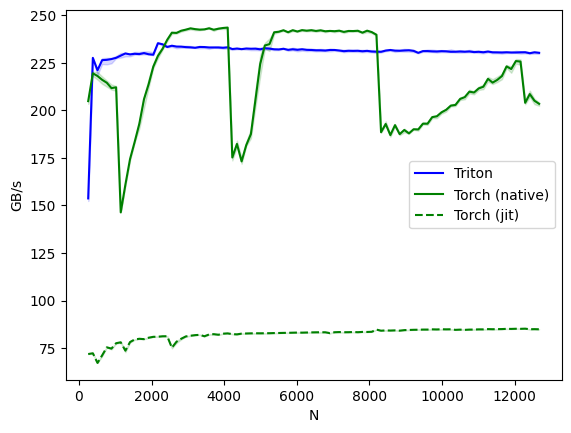

softmax-performance:
          N      Triton  Torch (native)  Torch (jit)
0     256.0  153.660028      204.800005    71.859648
1     384.0  227.555555      219.428568    72.262429
2     512.0  221.032050      217.999176    67.190567
3     640.0  226.337417      216.005270    71.165168
4     768.0  226.506919      214.461959    75.386501
5     896.0  226.908375      211.650280    74.721393
6    1024.0  227.555548      212.047718    77.540189
7    1152.0  228.724768      146.321997    78.039695
8    1280.0  229.870216      160.903509    73.631819
9    1408.0  229.365578      174.340022    78.158614
10   1536.0  229.682243      183.402983    79.519909
11   1664.0  229.517236      192.927532    79.878864
12   1792.0  230.066193      205.810680    79.692866
13   1920.0  229.441001      213.681111    80.441880
14   2048.0  229.196933      222.911566    80.908642
15   2176.0  235.243233      228.559238    80.967445
16   2304.0  234.674081      232.294214    81.198239
17   2432.0  233.246052  

In [19]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['N'],  # argument names to use as an x-axis for the plot
        x_vals=[128 * i for i in range(2, 100)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=[
            'triton',
            'torch-native',
            'torch-jit',
        ],  # possible values for `line_arg``
        line_names=[
            "Triton",
            "Torch (native)",
            "Torch (jit)",
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-'), ('green', '--')],  # line styles
        ylabel="GB/s",  # label name for the y-axis
        plot_name="softmax-performance",  # name for the plot. Used also as a file name for saving the plot.
        args={'M': 4096},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(M, N, provider):
    x = torch.randn(M, N, device='cuda', dtype=torch.float32)
    quantiles = [0.5, 0.2, 0.8]
    if provider == 'torch-native':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.softmax(x, axis=-1), quantiles=quantiles)
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: softmax(x), quantiles=quantiles)
    if provider == 'torch-jit':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: naive_softmax(x), quantiles=quantiles)
    gbps = lambda ms: 2 * x.nelement() * x.element_size() * 1e-9 / (ms * 1e-3)
    return gbps(ms), gbps(max_ms), gbps(min_ms)


benchmark.run(show_plots=True, print_data=True)